In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [31]:
# Load the dataset
df = pd.read_csv('Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [32]:
# Step 1: Correlation Analysis
correlations = df.corr()
print("Correlation Coefficients:\n", correlations['Gold_Price'])

Correlation Coefficients:
 Gold_Price    1.000000
USD_Index    -0.401637
GDP           0.815445
Oil_Price     0.783434
Name: Gold_Price, dtype: float64


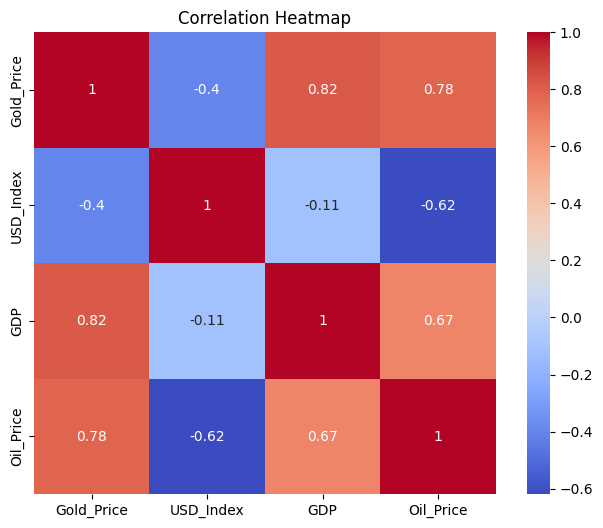

In [33]:
# Plotting correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

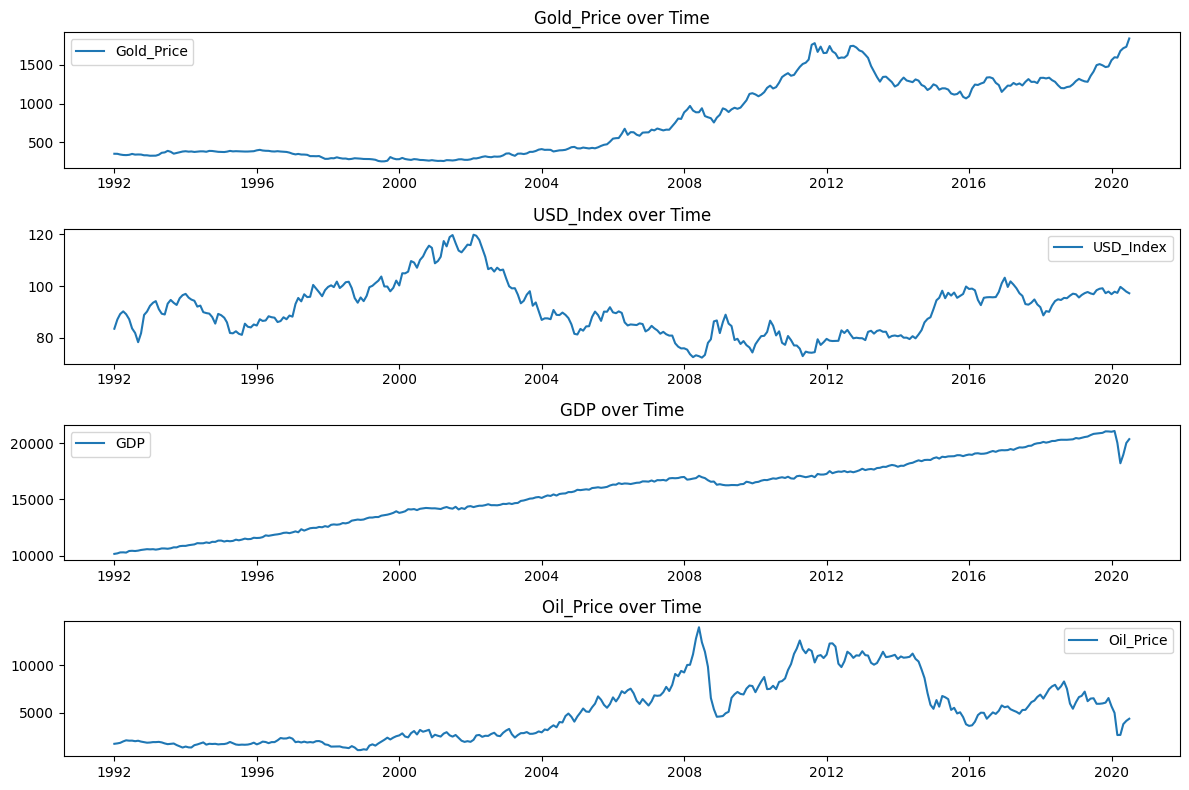

In [34]:
# Step 2: Data Visualization
# Plot the original series for each variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i+1)
    plt.plot(df.index, df[col], label=col)
    plt.title(f'{col} over Time')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 4: Prepare Data for LSTM Model
# Scaling the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df[['USD_Index', 'GDP', 'Oil_Price']])
scaled_target = scaler_target.fit_transform(df[['Gold_Price']])

In [ ]:
# Create sequences for LSTM model
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_target)):
    X.append(np.hstack((scaled_features[i-sequence_length:i], scaled_target[i-sequence_length:i])))
    y.append(scaled_target[i])
X, y = np.array(X), np.array(y)

In [ ]:
# Split into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Step 5: Building the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Single output for gold price prediction

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0932 - val_loss: 0.0086
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0244 - val_loss: 0.0926
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0142 - val_loss: 0.0282
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0102 - val_loss: 0.0659
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0111 - val_loss: 0.0381
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0099 - val_loss: 0.0421
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0104 - val_loss: 0.0245
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0126 - val_loss: 0.0502
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0081 - val_loss: 0.0332
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0086 - val_loss: 0.0339
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0066 - val_loss: 0.0312
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0077 - val_loss: 0.0336
E

In [ ]:
# Step 6: Model Predictions and Results Visualization
predictions = model.predict(X_test)
predictions = scaler_target.inverse_transform(predictions)
y_test_true = scaler_target.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


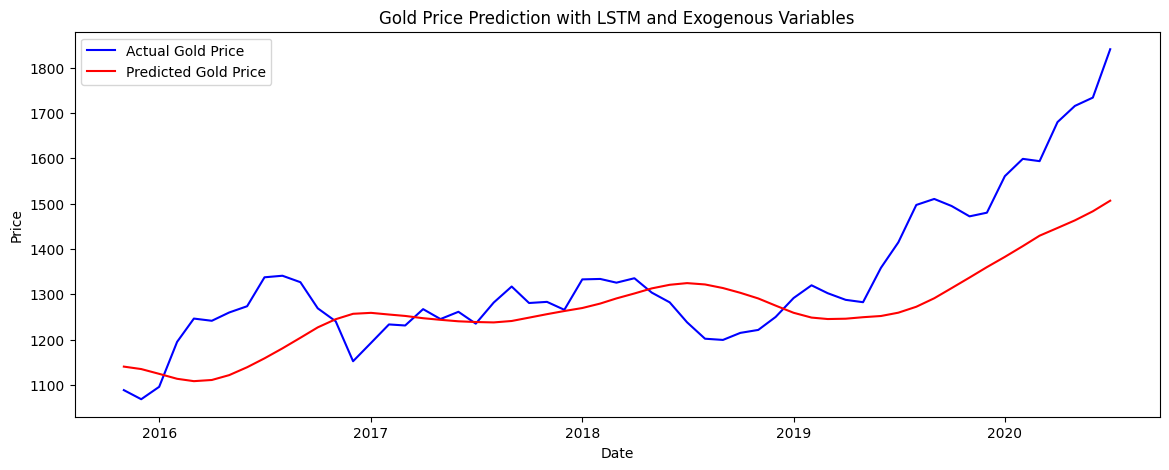

In [ ]:
# Visualize the results
plt.figure(figsize=(14, 5))
plt.plot(df.index[-len(y_test):], y_test_true, color='blue', label='Actual Gold Price')
plt.plot(df.index[-len(predictions):], predictions, color='red', label='Predicted Gold Price')
plt.title('Gold Price Prediction with LSTM and Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_true, predictions)
mse = mean_squared_error(y_test_true, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_true - predictions) / y_test_true)) * 100

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Evaluation Metrics:
Mean Absolute Error (MAE): 95.49396609443535
Mean Squared Error (MSE): 14894.937525476618
Root Mean Squared Error (RMSE): 122.04481769201271
Mean Absolute Percentage Error (MAPE): 6.80304342360306%
